# 1. Introduction
## Object:
* Case Selection > > Commodity Category: Sofa
* Quantity: 4400 items in 100 pages
* Screening Conditions: TMall, Sales Volume from High to Low, Price above 500 yuan

## Project Purpose:
1. Text analysis of commodity title, word cloud visualization
2. Statistical analysis of sales corresponding to different keywords word
3. Analysis of commodity price distribution
4. Analysis of sales distribution of goods
5. Average sales distribution of commodities in different price ranges
6. Analysis of the impact of commodity price on sales volume
7. Analysis of the impact of commodity price on sales
8. Average sales distribution of goods in different provinces

## Project Steps:
1. Data collection: Python crawls commodity data of taobao.com
2. Data cleaning and processing
3. Text analysis: Jieba segmentation, wordcloud visualization
4. Visualization of data histogram
5. Histogram visualization hist
6. Scatter visualization
7. Data regression analysis visual regplot

## Libraries:
Requests, retrying, missingno, Jieba, Matplotlib, wordcloud, imread, Seaborn, pyecharts, etc

# 2. Data Analysis
## (1) Crawling Data

To ensure that we can obtain sufficient data from every webpage of TMall, the following method are utilized:
* Using multithreading
* Modifying the parameter of headers
* Adding cycle crawling: Every cycle crawl those webpages that has not been successfully crawled, until all webpages are successfully crawled.

Notes: 
1. The commodity webpages of TMall are in JSON format, so the regular expression is used to parse.
2. The default encoding format in Python is ASCII format, Chinese characters cannot be printed correctly without modifying the encoding format, so an error will be reported when reading Chinese. The solution is just to add # -*- coding: utf-8 -*- or # coding=utf-8 (No spaces on both sides of =) at the beginning.
3. **import re** Regular Expression: In most cases, it can effectively analyze complex strings and extract relevant information.
4. **import xlwt** Xlwt is used to write XLS files, and xlrd is used to read XLS files.
5. **import requests** is used to get information from webpage.
6. **from retrying import retry** In the process of crawling data, we often encounter the situation of failed crawling. At this time, we use this module to retry crawling.
7. **from concurrent.futures import ThreadPoolExecutor** 
   * **concurrent.futures**: This module has the functions of thread pool and process pool, managing parallel programming tasks, dealing with non deterministic execution process, process / thread synchronization and so on.
   * current.Futures: The current.futures module provides two subclasses of Executor, which operate a thread pool and a process pool independently:
     Two subclasses are:
                          * concurrent.futures.ThreadPoolExecutor(max_workers)
                          * concurrent.futures.ProcessPoolExecutor(max_workers)
                            max_workers indicates the maximum number of workers executing tasks in parallel.
8. **import matplotlib** used to draw charts. 
9. **%matplotlib inline** In jupyter notebook, when you call the plot() function of matplotlib.pyplot to draw, or when you generate a figure canvas, you can generate images directly in your Python console.

In [1]:
# -*- coding: utf-8 -*-
import re
import xlwt
import time 
import requests
import pandas as pd
from pandas import Series, DataFrame
from retrying import retry
from concurrent.futures import ThreadPoolExecutor
import matplotlib
%matplotlib inline

In [ ]:
start = time.process_time() # Time counting starts

plist = [] # plist 为1-100页的URL的编号num
for i in range(1, 101): # the range of webpage number
    j = 44 * (i - 1) # 44 products shown in every webpage
    plist.append(j)
    
listno = plist
datatmsp = pd.DataFrame(columns = [])

while True:
    @retry(stop_max_attempt_number = 8) # Setting the max number of retrying
    def network_programming(num):
        url = 'https://s.taobao.com/search?initiative_id=tbindexz_201 \
               70306&ie=utf8&spm=a21bo.2017.201856-taobao-item.2&sourceId=tb.i \
               ndex&search_type=item&ssid=s5-e&commend=all&imgfile=&q=%E6%B2%99% \
               E5%8F%91&suggest=history_1&_input_charset=utf-8&wq=shafa&suggest_qu \
               ery=shafa&source=suggest&bcoffset=4&ntoffset=4&p4ppushleft=1%2C48&s=' + str(num)
        web = requests.get(url, headers = headers)
        web.encoding = 'utf-8'
        return web
    
    # Multithreading
    def multithreading():
        # the unsuccessfully-crawled webpages everytime
        number = listno
        event = []
        
        with ThreadPoolExecutor(max_workers = 10) as executor:
            for result in executor.map(network_programming, number, chunksize = 10): #Notes ↓（1）
                event.append(result)   
        return event
    
    # Hiding: modifying the headers. Note ↓ （2）
    headers = {'User-Agent':'Mozilla/5.0 (X11; Linux x86_64) \
                AppleWebKit/537.36 (KHTML, like Gecko) \
                Chrome/64.0.3282.167 Safari/537.36'}
    
    # Getting data from Json by multithreading
    listpg = []
    event = multithreading()
    for i in event:
        json = re.findall('"auctions":(.*?),"recommendAuctions"', i.text) # Note ↓ （3）
        if len(json):
            table = pd.read_json(json[0])
            datatmsp = pd.concat([datatmsp, table], axis = 0, ignore_index = True)
            
            pg = re.findall('"pageNum":(.*?),"p4pbottom_up"', i.text)[0]
            listpg.append(pg) # #Recording the page numbers of successfully-crawled webpages everytime
            
    lists = []
    for a in listpg:
        b = 44 * (int(a) - 1)
        lists.append(b) # #Turning the page numbers of successfully-crawled webpages into the num value in the URL
        
    listn = listno
    
    # Clearing the failed array every cycle 
    listno = []
    for p in listn:
        if p not in lists:
            listno.append(p) # Recording the page numbers of unsuccessfully-crawled webpages in the list for cyclic crawling
            
    if len(listno) == 0:
        break # Stop cycling when the number of unsuccessfully-crawled webpages is 0
        
datatmsp.to_excel('./data/datastmsp.xls', index = False) # Exporting data to excel

end = time.process_time() # Time counting stops
print("Crawling is finished, time consuming: ", end - start, 's')

Notes:
1. map(self, fn, *iterables, timeout=None, chunksize=1) 
   map()方法，similar to map() built in python (也就是映射).
   
   parameters：
              (1)一个可调用函数 fn
              (2)一个迭代器 iterables
              (3)超时时长 timeout
              (4)块数chuncksize 如果大于1, 迭代器会被分块处理
   feture：其返回结果与调用开始的顺序是一致的；在调用过程中不会产生阻塞，也就是说可能前者被调用执行结束之前，后者被调用已经执行结束了。
 
 
2. Because there may be anti crawlers on Taobao, it is necessary to use cookies to build the header to pretend to be a browser.
   
   Chrome User Agents: https://developers.whatismybrowser.com/useragents/explore/software_name/chrome/6
   
   
3. The regular expression **re.findall** method can return matching strings in the form of a list.
   re.findall(patern, string, flags=0)
   * pattern : 正则中的模式字符串。
   * string : 要被查找替换的原始字符串。
   * flags : 标志位，用于控制正则表达式的匹配方式，如：是否区分大小写，多行匹配等等。
   
           (.*)第一个匹配分组，  * 代表匹配除换行符之外的所有字符。

           (.*?)第二个匹配分组，*? 后面多个问号，代表非贪婪模式，也就是说只匹配符合条件的最少字符。

## (2) Data Cleaning & Processing

In [2]:
datatmsp = pd.read_excel('./data/datastmsp.xls') #Reading data

In [3]:
datatmsp.shape

(4392, 25)

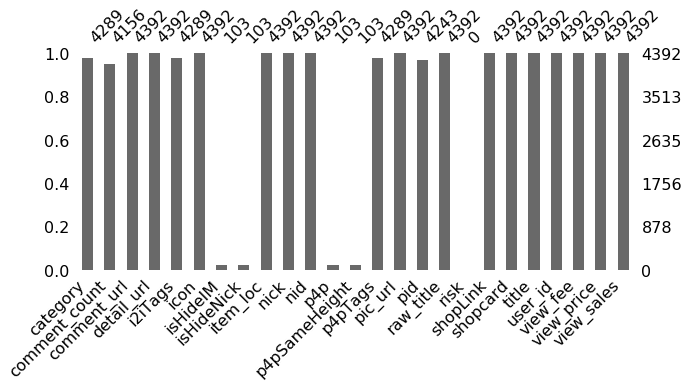

In [4]:
import missingno as msno # Missingno: visualization tool to observe data loss
msno.bar(datatmsp.sample(len(datatmsp)), figsize = (10, 4)) # Note ↓ （1）

# Deleting columns with more than half of the missing values
half_count = len(datatmsp)  / 2
datatmsp = datatmsp.dropna(thresh = half_count, axis = 1) # Note ↓ （2）

# Deleting duplicated rows
datatmsp = datatmsp.drop_duplicates() # Note ↓ （3）

Notes:

1. paremeters of missingno: (all parameters are passed to Matplotlib settings)

    * figsize = (20, 10) --- 调整图表的纵横比和大小。
    * width_ratios  =(15, 1) --- 调整主图和闪光图的相对大小。 
    * color = (0.25, 0.25, 0.25) --- 调整填充矩阵条目和迷你图的颜色。请注意 matplotlib以一个分数表示RGB值，所以例如0 = 0和1 = 255; 输入您的典型RGB值（122例如）传递122/255。 
    * fontsize = 16 --- 调整用于显示的字体大小。 
    * labels = True --- 设置此项以False关闭y轴标签。  
      
      
2. data.dropna(): 
   
   parameters:
             * axis = 0 (行), axis = 1 (列)
             * how = 'any' (删除带有空值的行/列，只要有一个空值，就删除整行/列)
               how = 'all' (整 行/列 都是空值时，才会被删除)
               thresh = 设定阈值，缺失值个数大于该阈值，整行(axis = 0)或整列(axis = 1)才会被删除
 
3. pandas.DataFrame.drop_duplicates(subset = None, keep = 'first', inplace = False)
   
   parameters:
             * subset = None 考虑所有列，将每列对应值都相同的行进行去重
               subset = ['B'] 表示只考虑'B'这列，将B列对应值相同的行进行去重
             * keep = 'first’ 表示保留第一次出现的重复行
               keep = 'last'False 表示保留最后一次出现的重复行
               keep = False 表示去除所有重复行 
             * inplace = False 表示生成一个副本,进行删除操作
               inplace = True 表示直接在原来的DataFrame上删除重复项


In [5]:
datatmsp.head() 

,category,comment_count,comment_url,detail_url,i2iTags,icon,item_loc,nick,nid,p4pTags,pic_url,pid,raw_title,shopLink,shopcard,title,user_id,view_fee,view_price,view_sales
0,NaN,NaN,https://click.simba.taobao.com/cc_im?p=%C9%B3%...,https://click.simba.taobao.com/cc_im?p=%C9%B3%...,NaN,"[{'title': '掌柜热卖宝贝', 'url': '//re.taobao.com/s...",广东 佛山,林氏木业家具旗舰店,556041494716,NaN,//g-search1.alicdn.com/img/bao/uploaded/i4/img...,NaN,北欧风格小户型实木架客厅L型布艺沙发组合,https://click.simba.taobao.com/cc_im?p=%C9%B3%...,"{'isTmall': True, 'delivery': [0, 1, 2007], 's...",林氏木业<span class=H>沙发</span>北欧家具小户型实木框客厅现代简约布艺<...,143584903,0.0,3480.0,328人付款
1,50020633.0,430.0,//detail.tmall.com/item.htm?id=528317610670&ad...,//detail.tmall.com/item.htm?id=528317610670&ad...,{'samestyle': {'url': '/search?type=samestyle&...,"[{'title': '尚天猫，就购了', 'url': '//www.tmall.com/...",广东 佛山,凯哲家具旗舰店,528317610670,[],//g-search3.alicdn.com/img/bao/uploaded/i4/i3/...,-1.038122e+09,凯哲家具欧式真皮沙发 头层牛皮雕花实木客厅整装转角沙发组合,//store.taobao.com/shop/view_shop.htm?user_num...,"{'isTmall': True, 'totalRate': 10000, 'deliver...",凯哲家具欧式真皮<span class=H>沙发</span> 头层牛皮雕花实木客厅整装转角...,867828093,0.0,7400.0,111人付款
2,50020633.0,434.0,//detail.tmall.com/item.htm?id=534013594681&ad...,//detail.tmall.com/item.htm?id=534013594681&ad...,{'samestyle': {'url': '/search?type=samestyle&...,"[{'title': '尚天猫，就购了', 'url': '//www.tmall.com/...",广东 佛山,雅居汇旗舰店,534013594681,[],//g-search2.alicdn.com/img/bao/uploaded/i4/i2/...,-1.255613e+09,雅居汇 欧式真皮转角沙发实木雕花客厅家具组合美式真皮转角沙发,//store.taobao.com/shop/view_shop.htm?user_num...,"{'isTmall': True, 'totalRate': 10000, 'deliver...",雅居汇 欧式真皮转角<span class=H>沙发</span>实木雕花客厅家具组合美式真...,1696287283,0.0,18800.0,25人付款
3,50020633.0,868.0,//detail.tmall.com/item.htm?id=45828269874&ns=...,//detail.tmall.com/item.htm?id=45828269874&ns=...,"{'samestyle': {'url': ''}, 'similar': {'url': ...","[{'title': '尚天猫，就购了', 'url': '//www.tmall.com/...",广东 江门,斯帝罗兰家具旗舰店,45828269874,[],//g-search1.alicdn.com/img/bao/uploaded/i4/i3/...,-1.774408e+09,斯帝罗兰简约现代真皮沙发组合整装客厅转角头层牛皮三人沙发家具,//store.taobao.com/shop/view_shop.htm?user_num...,"{'isTmall': True, 'totalRate': 10000, 'deliver...",斯帝罗兰简约现代真皮<span class=H>沙发</span>组合整装客厅转角头层牛皮三...,2485585242,800.0,8699.0,93人付款
4,50020632.0,81.0,//detail.tmall.com/item.htm?id=560306420180&ns...,//detail.tmall.com/item.htm?id=560306420180&ns...,{'samestyle': {'url': '/search?type=samestyle&...,"[{'title': '尚天猫，就购了', 'url': '//www.tmall.com/...",浙江 杭州,kuka顾家家居旗舰店,560306420180,[],//g-search3.alicdn.com/img/bao/uploaded/i4/i3/...,-1.912232e+09,!【新款】现顾家kuka北欧布艺沙发客厅大小户型现代简约组合2037,//store.taobao.com/shop/view_shop.htm?user_num...,"{'isTmall': True, 'totalRate': 10000, 'deliver...",!【新款】现顾家kuka北欧布艺<span class=H>沙发</span>客厅大小户型现...,2096542875,0.0,2999.0,142人付款


According to the purpose of this project, the following attributes are needed for this analysis:

item_loc, raw_title, view_price, view_sales

In [6]:
# Taking out these four columns of data
data = datatmsp[['item_loc', 'raw_title', 'view_price', 'view_sales']]
data.head()

,item_loc,raw_title,view_price,view_sales
0,广东 佛山,北欧风格小户型实木架客厅L型布艺沙发组合,3480.0,328人付款
1,广东 佛山,凯哲家具欧式真皮沙发 头层牛皮雕花实木客厅整装转角沙发组合,7400.0,111人付款
2,广东 佛山,雅居汇 欧式真皮转角沙发实木雕花客厅家具组合美式真皮转角沙发,18800.0,25人付款
3,广东 江门,斯帝罗兰简约现代真皮沙发组合整装客厅转角头层牛皮三人沙发家具,8699.0,93人付款
4,浙江 杭州,!【新款】现顾家kuka北欧布艺沙发客厅大小户型现代简约组合2037,2999.0,142人付款


In [7]:
# Spliting the provinces and cities listed in item_loc to get two columns: 'province' and 'city'
data['province'] = data.item_loc.apply(lambda x: x.split()[0]) # Note ↓ （1）

data['city'] = data.item_loc.apply(lambda x: x.split()[0] if len(x) < 4 else x.split()[1]) # Note ↓ （2）

# Extracting the numbers in the 'view_sales' column to get the 'sales_volume' column
data['sales_volume'] = data.view_sales.apply(lambda x: x.split('人')[0]) # .split() Note ↓ （3）

# Viewing data type of every column
data.dtypes # Note ↓ （4）

C:\Users\vince\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\vince\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\vince\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

item_loc         object
raw_title        object
view_price      float64
view_sales       object
province         object
city             object
sales_volume     object
dtype: object

Notes: 
1. DataFrame.apply(func, axis = 0, broadcast = None, raw = False, reduce = None, result_type = None, args = (), **kwds)  
parameters:
       
       * func : function, Function to apply to each column or row.
       * axis = 0, 'index'       apply function to each column.
         axis = 1, 'columns'     apply function to each row.
       * broadcast : Only relevant for aggregation functions (聚合函数):
         broadcast = False or None : returns a Series whose length is the length of the index or the number of columns 
                                     (based on the axis parameter)
         broadcast = True :  results will be broadcast to the original shape of the frame, 
                             the original index and columns will be retained.
         (Deprecated since version 0.23.0: 
                                   This argument will be removed in a future version, replaced by result_type=’broadcast’.)
       * raw = False : passes each row or column as a Series to the function.
         raw = True : the passed function will receive ndarray objects instead. 
                      If you are just applying a NumPy reduction function this will achieve much better performance.
       * reduce : 
         If the DataFrame is empty, apply will use reduce to determine whether the result should be a Series or a DataFrame. 
         reduce = None : apply’s return value will be guessed by calling func on an empty Series 
                         (note: while guessing, exceptions raised by func will be ignored).
         reduce = True : a Series will always be returned.
         reduce = False : a DataFrame will always be returned.
         (Deprecated since version 0.23.0: 
                                   This argument will be removed in a future version, replaced by result_type='reduce'.)
       * result_type : {'expand', 'reduce', 'broadcast', None}, **These only act when axis=1 (columns):**
         result_type = 'expand' : list-like results will be turned into columns.
         result_type = 'reduce' : returns a Series if possible rather than expanding list-like results. 
                                  This is the opposite of ‘expand’.
         result_type = 'broadcast' : results will be broadcast to the original shape of the DataFrame, 
                                     the original index and columns will be retained.
         result_type = None : depends on the return value of the applied function: 
                              list-like results will be returned as a Series of those.  
                              However if the apply function returns a Series these are expanded to columns.
       * args : tuple, positional arguments to pass to func in addition to the array/series.
       * **kwds : Additional keyword arguments to pass as keywords arguments to func.
       https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.apply.html 
       
       
2. Since the provinces and cities of the municipality directly under the central government （直辖市）are the same, it is judged according to the character length.


3. .split(以什么记号进行分割, 分割成几个部分<如果想分割为两个部分：1>)  
   https://www.runoob.com/python/att-string-split.html  
   
   
4. DataFrame.dtypes：  
   This returns a Series with the data type of each column.   
   The result’s index is the original DataFrame’s columns.

In [8]:
# Converting data types
data['sales_volume'] = data.sales_volume.astype('int') # Note ↓ （1）
list_col = ['province', 'city']
for i in list_col:
    data[i] = data[i].astype('category') # Note ↓ （2）

# Deleting unused columns
data = data.drop(['item_loc', 'view_sales'], axis=1)

C:\Users\vince\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\vince\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Notes:  

1. ndarray.astype(dtype, order = 'K', casting = 'unsafe', subok = True, copy = True)  
Parameters:  	
           
           * dtype = str or dtype : Typecode or data-type to which the array is cast.
           * order : {'C', 'F', 'A', 'K'}, (optional) (Default is 'K'.): Controls the memory layout order of the result. 
             order = 'C' : C order, 
             order = 'F' : Fortran order, 
             order = 'A' : 'F' order if all the arrays are Fortran contiguous, 'C' order otherwise, 
             order = 'K' : as close to the order the array elements appear in memory as possible. 
           * casting : {'no', 'equiv', 'safe', 'same_kind', 'unsafe'}, (optional): 
                       Controls what kind of data casting may occur. Defaults to ‘unsafe’ for backwards compatibility.
             casting = 'no' : the data types should not be cast at all.
             casting = 'equiv' : only byte-order changes are allowed.
             casting = 'safe' : only casts which can preserve values are allowed.
             casting = 'same_kind' : only safe casts or casts within a kind, like float64 to float32, are allowed.
             casting = 'unsafe' : any data conversions may be done.
           * subok : bool, (optional)
             subok = True : sub-classes will be passed-through (default),
             subok = False : the returned array will be forced to be a base-class array.
           * copy : bool, (optional)
             copy = True : astype always returns a newly allocated array. 
             copy = False : If this is set to false, and the dtype, order, and subok requirements are satisfied, 
                            the input array is returned instead of a copy.
             https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.astype.html
             
        
2. When the data values in a column (field) of dataframe are all values in a limited set of values, for example: gender is male and female, limited and unique. This column can be stored and counted by category data type.   

   (1) One advantage of using category data is that it can save time and space.
       *The memory occupied by category is directly proportional to the number of Categorical types and the length of data.   
       *On the contrary, the memory occupied by object is a constant multiplied by the length of data.
   (2) In addition to saving memory, another additional benefit is that the computing efficiency has been greatly improved.  
   http://liao.cpython.org/pandas15/

In [9]:
data.head()

,raw_title,view_price,province,city,sales_volume
0,北欧风格小户型实木架客厅L型布艺沙发组合,3480.0,广东,佛山,328
1,凯哲家具欧式真皮沙发 头层牛皮雕花实木客厅整装转角沙发组合,7400.0,广东,佛山,111
2,雅居汇 欧式真皮转角沙发实木雕花客厅家具组合美式真皮转角沙发,18800.0,广东,佛山,25
3,斯帝罗兰简约现代真皮沙发组合整装客厅转角头层牛皮三人沙发家具,8699.0,广东,江门,93
4,!【新款】现顾家kuka北欧布艺沙发客厅大小户型现代简约组合2037,2999.0,浙江,杭州,142


## (3) Data Mining and Analysis

In [10]:
# Text analysis of the 'raw_title' column:

# Turning to list
title = data.raw_title.values.tolist() # Note ↓ （1）

# Using word breaker: jieba 
# Word segmentation for each title: using the lcut function
import jieba
title_s = []
for line in title:
    title_cut = jieba.lcut(line) # Note ↓ （2）
    title_s.append(title_cut)
    
# Filter every element (str) in title_s（list of lists form） to remove unnecessary words from the stopwords list:
# Importing the stopwords list:
stopwords = pd.read_excel('./data/stopwords.xlsx')
stopwords = stopwords.stopword.values.tolist() # Note ↓ （3）  # Note ↓ （4）  # Note ↓ （5）

# Removing stopwords:
title_clean = []
for line in title_s:
    line_clean = []
    for word in line:
        if word not in stopwords:
            line_clean.append(word)
    title_clean.append(line_clean)

# Because the next step is to count the number of each word, in order to be accurate, 
# the elements of each list in the filtered title_clean are de duplicated, 
# that is, each word from one segmented title is unique.

# Removing duplicates
title_clean_dist = []
for line in title_clean:
    line_dist = []
    for word in line:
        if word not in line_dist:
            line_dist.append(word)
    title_clean_dist.append(line_dist)
    
# Converting title_clean_dist (list of lists form) to only one list: allwords_clean_dist
allwords_clean_dist = []
for line in title_clean_dist:
    for word in line:
        allwords_clean_dist.append(word)
        
# Turning the list allwords_clean_dist to DataFrame
df_allwords_clean_dist = pd.DataFrame({'allwords': allwords_clean_dist})

# Classifying and summarizing the words filtered and de duplicated
word_count = df_allwords_clean_dist.allwords.value_counts().reset_index() # Note ↓ （6）  # Note ↓ （7）
# Adding columns' names
word_count.columns = ['word', 'count']

word_count.head()

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\vince\AppData\Local\Temp\jieba.cache
Loading model cost 2.387 seconds.
Prefix dict has been built succesfully.


,word,count
0,沙发,2897
1,组合,2800
2,客厅,2570
3,小户型,2348
4,简约,1908


Notes:

1. numpy.ndarray.tolist()      
https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.tolist.html


2. jieba:    
jieba.cut() & jieba.lcut()< directly returns list >      

    parameters:

        * String required participle
        * cut_all : Used to control whether full mode is adopted
          cut_all = False(Default) : Try to segment the statement with the most accuracy, there is no redundant data, 
                                     so it is suitable for text analysis.  
          cut_all = True : It is very fast to segment all possible words in the sentence, but there is redundant data.   
        * HMM : Used to control whether to use HMM model

https://github.com/fxsjy/jieba  

https://www.jianshu.com/p/e8b5d01ca073  

https://blog.csdn.net/codejas/article/details/80356544


3. stopwords:  
Chineses stopwords : https://github.com/YueYongDev/stopwords


4. stopwords = pd.read_excel('./data/stopwords.xlsx') * 1st stopwords : DataFrame read from excel file  
   stopwords = stopwords.stopword.values.tolist() 
               * 2nd stopwords : list form
               * 3rd stopwords : = 1st stopwords
               * 1st stopword : the attribute(column) of the DataFrame 'stopwords'
               
5. DataFrame values.tolist(): https://stackoverflow.com/questions/34838378/dataframe-values-tolist-datatype


6. Series.value_counts(self, normalize = False, sort = True, ascending = False, bins = None, dropna = True): 

   (1) Return a Series containing counts of unique values.  
   (2) The resulting object will be in descending order so that the first element is the most frequently-occurring element.  
   (3) Excludes NA values by default.  

   parameters:	
             * normalize : boolean, default False
               normalize = True : the object returned will contain the relative frequencies of the unique values.  
             * sort : boolean, default True
                      Sort by frequencies.  
             * ascending : boolean, default False
                      Sort in ascending order.
             * bins : integer, optional
                      Rather than count values, group them into half-open bins, a convenience for pd.cut, 
                      only works with numeric data.
             * dropna : boolean, default True
                      Don’t include counts of NaN.  
    https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.value_counts.html  
    
    
7. Series.reset_index(self, level = None, drop = False, name = None, inplace = False)  
    (1) Generate a new DataFrame or Series with the index reset.  
    (2) This is useful when the index needs to be treated as a column, or when the index is meaningless and needs to be reset to the default before another operation.  

    parameters:	
               * level : int, str, tuple, or list, default optional
                         For a Series with a MultiIndex, only remove the specified levels from the index.  
                         Removes all levels by default.  
               * drop : bool, default False
                        Just reset the index, without inserting it as a column in the new DataFrame.
               * name : object, optional
                        The name to use for the column containing the original Series values. 
                        Uses self.name by default.  
                        This argument is ignored when drop is True.
               * inplace : bool, default False
                           Modify the Series in place (do not create a new object).
    Returns: 	
            Series or DataFrame:
            * drop = False (the default), a DataFrame is returned. 
              The newly created columns will come first in the DataFrame, followed by the original Series values.   
            * drop = True, a Series is returned.   
            * In either case, if inplace = True, no value is returned.  
    https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.reset_index.html#pandas.Series.reset_index

## Supplementary Step
Remarks:  
Observe the words in the word_count, if you find that the default dictionary of jieba cannot meet the needs of word segmentation, some words are cut out because they do not exist in the default dictionary, so need to add new words to the dictionary according to the needs.  
(can also add or delete directly in dict.txt and load the modified dict.txt)
https://github.com/fxsjy/jieba  >>>  主要功能  >>>  2.添加自定义词典

1. Sort out the words needed to be added and generate an excel file named 'add_words.xlsx', only one attribute in this file, which is named 'word'.  


2. codes:       
    
    add_words = pd.read_excel('add_words.xlsx')  # Importing sorted words to be added  

    for w in add_words.word:  
        jieba.add_word(w , freq = 1000)  # Adding custom new words to the default dictionary of jieba  # Note ↓ （1）  


3. Executing the above segmentation, filtering, de duplication, summary and other codes once again, to get a new word_count.  


4. optional codes: 
  
    word_count.to_excel('word_count.xlsx', index = False)  # Exporting data 
    
    
Notes:  
1. jieba.add_word(word, freq = None, tag = None)  
   https://github.com/fxsjy/jieba

## (4) Word Cloud Visualization

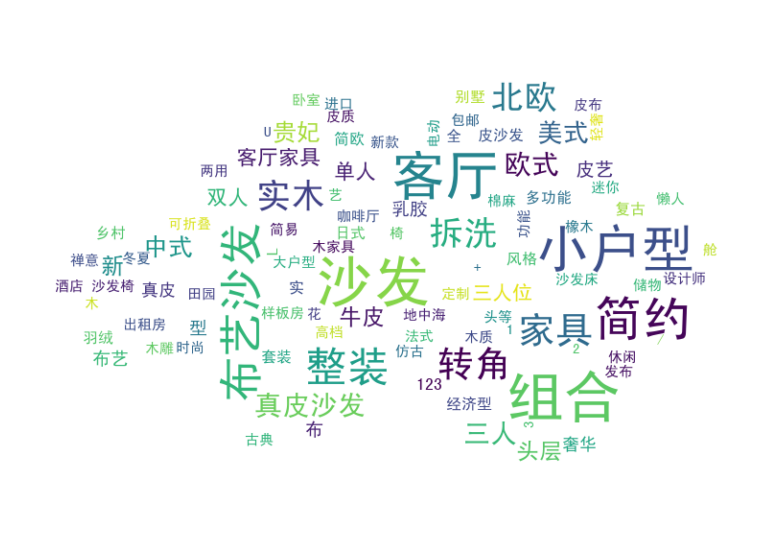

In [11]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from imageio import imread # Drawing pattern outline  # Note ↓ （1）


plt.figure(figsize = (20, 10)) # Note ↓ （2）

pic = imread("./images/shafa.jpg")

w_c = WordCloud(font_path = "./data/simhei.ttf",  # Setting font  # Note ↓ （3）
               background_color = 'white', # The default is black. It's set to white here.
               mask = pic, # Modeling cover
               max_font_size = 60, # Font maximum
               margin = 1)

wc = w_c.fit_words({x[0] : x[1] for x in word_count.head(100).values}) # Taking the first 100 words for visualization
                                                                     # Note ↓ （4）
plt.imshow(wc, interpolation = 'bilinear') # Graph optimization  # Note ↓ （5）
plt.axis("off") # Hiding axises  # Note ↓ （6）
plt.show() # Note ↓ （7）  

## Conclusion:  
1. Words such as '沙发', '组合', '客厅', '小户型' and '简约' are frequently used.  
2. Among the words describing sofa material, '布艺沙发' appears the most frequently.  
3. Among the words describing sofa style, '简约' appears the most frequently.   
4. Among the words used to describe the type of house the sofa is suitable for, '小户型' appears the most frequently.  

Notes:

1. from scipy.misc import imread = from imageio import imread  
python使用from scipy.misc import imread报错：ImportError: cannot import name imread  
This is due to the problem with the version of Scipy.  

  resolution:  

            (1) 把scipy降级到1.2.1 :    pip install scipy == 1.2.1

            (2) 使用imageio中的imread代替
           
2. matplotlib.pyplot.figure(num = None, figsize = None, dpi = None, facecolor = None, edgecolor = None, frameon = True, FigureClass = <class 'matplotlib.figure.Figure'>, clear = False, **kwargs)

    parameters:	    
    
          ** num : integer or string, optional, default: None  
          
                 (1) If not provided:
                     - A new figure will be created, and the figure number will be incremented.   
                     - The figure objects holds this number in a number attribute.
            
                 (2) If num is provided: 
                               <1> and a figure with this id already exists, make it active, and returns a reference to it.  
                               <2> If this figure does not exists, create it and returns it. 
                                
                 (3) If num is a string: the window title will be set to this figure's num.           
               
        
          ** figsize : (float, float), optional, default: None
                       - width, height in inches.   
                       - If not provided, defaults to rcParams["figure.figsize"] = [6.4, 4.8] = [6.4, 4.8].
     
          ** dpi : integer, optional, default: None
                   - resolution of the figure.     
                   - If not provided, defaults to rcParams["figure.dpi"] = 100.0 = 100.  

          ** facecolor : color spec
                         - the background color.   
                         - If not provided, defaults to rcParams["figure.facecolor"] = 'white' = 'w'.  

          ** edgecolor : color spec
                         - the border color.   
                         - If not provided, defaults to rcParams["figure.edgecolor"] = 'white' = 'w'.  

          ** frameon : bool, optional, default: True  
                       - If False, suppress drawing the figure frame.

          ** FigureClass : subclass of Figure  
                           - Optionally use a custom Figure instance.  

          ** clear : bool, optional, default: False  
                     - If True and the figure already exists, then it is cleared.   

    https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.figure.html
    
3. wordcloud.WordCloud(  
  
**font_path = None,**   
> string  
> Font path to the font that will be used (OTF or TTF).   
> Defaults to DroidSansMono path on a Linux machine.     
> If you are on another OS or don’t have this font, you need to adjust this path.    

**width = 400,** 
> int (default = 400)  
> Width of the canvas.  
   
**height = 200,**  
> int (default = 200)  
> Height of the canvas.    

**margin = 2,**  

**ranks_only = None,**   

**prefer_horizontal = 0.9,** 
> float (default = 0.90)  
> The ratio of times to try horizontal fitting as opposed to vertical.  
> If prefer_horizontal < 1, the algorithm will try rotating the word if it doesn’t fit.     
  (There is currently no built-in way to get only vertical words.)  

**mask = None,** 
> nd-array or None (default = None)
> If not None, gives a binary mask on where to draw words.  
> If mask is not None, width and height will be ignored and the shape of mask will be used instead.  
> All white (#FF or #FFFFFF) entries will be considerd “masked out” while other entries will be free to draw on.   
[This changed in the most recent version!]

**scale = 1,**  
> float (default = 1)  
> Scaling between computation and drawing.  
> For large word-cloud images, using scale instead of larger canvas size is significantly faster, but might lead to a coarser fit for the words.  
  
**color_func = None,**   
> callable, default = None  
> Callable with parameters word, font_size, position, orientation, font_path, random_state that returns a PIL color for each word.  
> Overwrites “colormap”. See colormap for specifying a matplotlib colormap instead.   
> To create a word cloud with a single color, use:{ color_func=lambda *args, **kwargs: "white" }.   
> The single color can also be specified using RGB code. For example, { color_func=lambda *args, **kwargs: (255,0,0) } sets color to red.  

**max_words = 200,**  
> number (default = 200)  
> The maximum number of words.  

**min_font_size = 4,**  
> int (default = 4)
> Smallest font size to use.   
> Will stop when there is no more room in this size.  

**stopwords = None,** 
> set of strings or None  
> The words that will be eliminated. 
> If None, the build-in STOPWORDS list will be used.  
> Ignored if using generate_from_frequencies.  

**random_state = None,**  
> int or None  
> Return a PIL color for each word.  
  
**background_color = 'black',**  
> color value (default = 'black')  
> Background color for the word cloud image.  

**max_font_size = None,**  
> int or None (default = None)  
> Maximum font size for the largest word.  
> If None, height of the image is used.

**font_step = 1,**  
> int (default = 1)  
> Step size for the font.   
> font_step > 1 might speed up computation but give a worse fit.    

**mode = 'RGB',**
> string (default = 'RGB')   
> Transparent background will be generated when mode is 'RGBA' and background_color is None.    

**relative_scaling = 'auto',**  
> float (default = 'auto')   
> Importance of relative word frequencies for font-size.    
> With relative_scaling = 0, only word-ranks are considered.   
> With relative_scaling = 1, a word that is twice as frequent will have twice the size.   
> If you want to consider the word frequencies and not only their rank, relative_scaling around 0.5 often looks good.   
> If 'auto' it will be set to 0.5 unless repeat is true, in which case it will be set to 0.  

**regexp = None,**
> string or None (optional)  
> Regular expression to split the input text into tokens in process_text.  
> If None is specified, { r"\w[\w']+" } is used.  
> Ignored if using generate_from_frequencies.  

**collocations = True,**  
> bool, default = True  
> Whether to include collocations (bigrams) of two words.  
> Ignored if using generate_from_frequencies.  

**colormap = None,**  
> string or matplotlib colormap, default = 'viridis'   
> Matplotlib colormap to randomly draw colors from for each word.  
> Ignored if 'color_func' is specified.  

**normalize_plurals = True,**  
> bool, default = True   
> Whether to remove trailing 's' from words.   
> If True and a word appears with and without a trailing 's', the one with trailing 's' is removed and its counts are added to the version without trailing 's' – unless the word ends with 'ss'.  
> Ignored if using generate_from_frequencies.  

**contour_width = 0,**  
> float (default = 0)  
> If mask is not None and contour_width > 0, draw the mask contour.  

**contour_color = 'black',**  
> color value (default = 'black')  
> Mask contour color.  

**repeat = False,**  
> bool, default = False  
> Whether to repeat words and phrases until max_words or min_font_size is reached.  

**include_numbers = False,**  
> bool, default = False  
> Whether to include numbers as phrases or not.  

**min_word_length = 0**)  
> int, default = 0   
> Minimum number of letters a word must have to be included.  
  
  
以上parameters内容中出现的{}只表示一个整体，没有任何符号或用法上的含义。   
Introduction(English version) https://amueller.github.io/word_cloud/generated/wordcloud.WordCloud.html  
介绍（中文版本）https://www.cnblogs.com/delav/articles/7837975.html  
Example: https://www.cnblogs.com/yjz8888/p/10152535.html  


4. fit_words(frequencies):  
   Generate word cloud based on word frequency.
   
   
5. matplotlib.pyplot.imshow() used to display an image.   

matplotlib.pyplot.imshow(  
  
**X,**  
> (1) array-like or PIL image  
> (2) The image data. Supported array shapes are:  
> *(M, N): an image with scalar data. The data is visualized using a colormap.  
> *(M, N, 3): an image with RGB values (0-1 float or 0-255 int).  
> *(M, N, 4): an image with RGBA values (0-1 float or 0-255 int), i.e. including transparency.  
> (3) The first two dimensions (M, N) define the rows and columns of the image.  
> (4) Out-of-range RGB(A) values are clipped.  

**cmap = None,**  
> (1) str or Colormap, optional  
> (2) The Colormap instance or registered colormap name used to map scalar data to colors.   
> (3) This parameter is ignored for RGB(A) data.  
> (4) Defaults to rcParams["image.cmap"] = 'viridis'.  

**norm = None,**  
> (1) Normalize, optional   
> (2) The Normalize instance used to scale scalar data to the [0, 1] range before mapping to colors using cmap.  
> (3) By default, a linear scaling mapping the lowest value to 0 and the highest to 1 is used.  
> (4) This parameter is ignored for RGB(A) data.  

**aspect = None,**  
> (1) {'equal', 'auto'} or float, optional  
> (2) Controls the aspect ratio of the axes. The aspect is of particular relevance for images since it may distort the image, i.e. pixel will not be square.  
> (3) This parameter is a shortcut for explicitly calling Axes.set_aspect. See there for further details.  
> *'equal': Ensures an aspect ratio of 1. Pixels will be square (unless pixel sizes are explicitly made non-square in data coordinates using extent).  
> *'auto': The axes is kept fixed and the aspect is adjusted so that the data fit in the axes. In general, this will result in non-square pixels.  
> (4) If not given, use rcParams["image.aspect"] = 'equal' (default: 'equal').  

**interpolation = None,**  
> (1) str, optional  
> (2) The interpolation method used. If None rcParams["image.interpolation"] = 'nearest' is used, which defaults to 'nearest'.  
> (3) Supported values are 'none', 'nearest', 'bilinear', 'bicubic', 'spline16', 'spline36', 'hanning', 'hamming', 'hermite', 'kaiser', 'quadric', 'catrom', 'gaussian', 'bessel', 'mitchell', 'sinc', 'lanczos'.  
> (4) If interpolation is 'none', then no interpolation is performed on the Agg, ps, pdf and svg backends. Other backends will fall back to 'nearest'. Note that most SVG renders perform interpolation at rendering and that the default interpolation method they implement may differ.  
> (5) See Interpolations for imshow/matshow for an overview of the supported interpolation methods.  
> (6) Some interpolation methods require an additional radius parameter, which can be set by filterrad. Additionally, the antigrain image resize filter is controlled by the parameter filternorm.  

**alpha = None,**  
> (1) scalar, optional   
> (2) The alpha blending value, between 0 (transparent) and 1 (opaque).   
> (3) This parameter is ignored for RGBA input data.  

**vmin = None,   
vmax = None,**   
> (1) scalar, optional  
> (2) When using scalar data and no explicit norm, vmin and vmax define the data range that the colormap covers.   
> (3) By default, the colormap covers the complete value range of the supplied data.   
> (4) vmin, vmax are ignored if the norm parameter is used.  

**origin = None,**   
> (1) {'upper', 'lower'}, optional    
> (2) Place the [0,0] index of the array in the upper left or lower left corner of the axes. The convention 'upper' is typically used for matrices and images. If not given, rcParams["image.origin"] = 'upper' is used, defaulting to 'upper'.   
> (3) Note that the vertical axes points upward for 'lower' but downward for 'upper'.  
> (4) See the origin and extent in imshow tutorial for examples and a more detailed description.   

**extent = None,**  
> (1) scalars (left, right, bottom, top), optional  
> (2) The bounding box in data coordinates that the image will fill. The image is stretched individually along x and y to fill the box.  
> (3) The default extent is determined by the following conditions. Pixels have unit size in data coordinates. Their centers are on integer coordinates, and their center coordinates range from 0 to columns-1 horizontally and from 0 to rows-1 vertically.  
> (4) Note that the direction of the vertical axis and thus the default values for top and bottom depend on origin:  
> *For origin == 'upper' the default is (-0.5, numcols-0.5, numrows-0.5, -0.5).  
> *For origin == 'lower' the default is (-0.5, numcols-0.5, -0.5, numrows-0.5).  
> (5) See the origin and extent in imshow tutorial for examples and a more detailed description.  

**shape = <deprecated parameter>,**   
    
**filternorm = 1,**  
> (1) bool, optional, default: True  
> (2) A parameter for the antigrain image resize filter (see the antigrain documentation). If filternorm is set, the filter normalizes integer values and corrects the rounding errors. It doesn't do anything with the source floating point values, it corrects only integers according to the rule of 1.0 which means that any sum of pixel weights must be equal to 1.0. So, the filter function must produce a graph of the proper shape.  
  
**filterrad = 4.0,**  
> (1) float > 0, optional, default: 4.0  
> (2)The filter radius for filters that have a radius parameter, i.e. when interpolation is one of: 'sinc', 'lanczos' or 'blackman'.  
  
**imlim = <deprecated parameter>,**  
    
**resample = None,**  
> (1) bool, optional  
> (2) When True, use a full resampling method.   
> (3) When False, only resample when the output image is larger than the input image.    

**url = None,**  
> (1) str, optional   
> (2) Set the url of the created AxesImage. See Artist.set_url.    

***,**      

**data = None,**  

**kwargs)  
> (1) Artist properties  
> (2) These parameters are passed on to the constructor of the AxesImage artist.  
  
https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.imshow.html  

6. matplotlib.pyplot.axis(*args, **kwargs)  
    Convenience method to get or set some axis properties.

    Call signatures:  

                   xmin, xmax, ymin, ymax = axis()  
                   xmin, xmax, ymin, ymax = axis([xmin, xmax, ymin, ymax])  
                   xmin, xmax, ymin, ymax = axis(option)  
                   xmin, xmax, ymin, ymax = axis(**kwargs)   
                   
    Parameters:	
          
          * xmin, xmax, ymin, ymax : float, optional  
            (1) The axis limits to be set.   
            (2) Either none or all of the limits must be given.   
            (3) This can also be achieved using:  
                                                ax.set(xlim=(xmin, xmax), ylim=(ymin, ymax))  

          * option : bool or str  
                     If a bool, turns axis lines and labels on or off. 
                     If a string, possible values are:  
                     (1) Value : Description  
                     (2) 'on' : Turn on axis lines and labels. Same as True.  
                     (3) 'off' : Turn off axis lines and labels. Same as False.  
                     (4) 'equal' : Set equal scaling (i.e., make circles circular) by changing axis limits.  
                     (5) 'scaled' : Set equal scaling (i.e., make circles circular) by changing dimensions of the plot box.  
                     (6) 'tight' : Set limits just large enough to show all data.  
                     (7) 'auto' : Automatic scaling (fill plot box with data).  
                     (8) 'normal' : Same as 'auto'; deprecated.  
                     (9) 'image' : 'scaled' with axis limits equal to data limits.  
                     (10) 'square' : Square plot; similar to 'scaled', but initially forcing xmax-xmin = ymax-ymin.  
                       
          * emit : bool, optional, default True  
                   Whether observers are notified of the axis limit change.   
                   This option is passed on to set_xlim and set_ylim.   
                   
https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.axis.html  

7. matplotlib.pyplot.show(*args, **kw)
   Display a figure.  
   https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.show.html?highlight=plt%20show  

   Difference between plt.show() & plt.imshow():  
   The plt.imshow() function processes the oata of image and displays its format, but it cannot display the image.  
   Then follow plt.imshow() to display the image.  

## (5) Statistical Analysis of the Impact of Different Keywords on Sales Volume

In [12]:
import numpy as np

w_s_sum = []
for w in word_count.word:
    i = 0
    s_list = []
    for t in title_clean_dist:
        if w in t:
            try:
                s_list.append(data.sales_volume[i])
            except:
                s_list.append(0)
        i += 1
    w_s_sum.append(sum(s_list))
    
df_w_s_sum = pd.DataFrame({'w_s_sum': w_s_sum})

In [13]:
df_w_s_sum.head()

,w_s_sum
0,354926
1,347685
2,342496
3,314679
4,275670


In [14]:
word_count.head()

,word,count
0,沙发,2897
1,组合,2800
2,客厅,2570
3,小户型,2348
4,简约,1908


In [15]:
df_word_sum = pd.concat([word_count, df_w_s_sum], axis = 1, ignore_index = True) # Note ↓ （1）
df_word_sum.columns = ['word', 'count', 'w_s_sum']

Notes:  
  
1. pandas.concat(objs, axis = 0, join = 'outer', join_axes = None, ignore_index = False, keys = None, levels = None, names = None, verify_integrity = False, sort = None, copy = True)  

(1) Concatenate pandas objects along a particular axis with optional set logic along the other axes.  

(2) Can also add a layer of hierarchical indexing on the concatenation axis, which may be useful if the labels are the same (or overlapping) on the passed axis number.

pandas.concat(  

**objs,**   
> a sequence or mapping of Series or DataFrame objects  
> If a dict is passed, the sorted keys will be used as the keys argument, unless it is passed, in which case the values will be selected (see below).  
> Any None objects will be dropped silently unless they are all None in which case a ValueError will be raised.  

**axis = 0,**   
> axis : {0/'index', 1/'columns'}, default 0  
> The axis to concatenate along.  

**join = 'outer',**   
> join : {'inner', 'outer'}, default 'outer'  
> How to handle indexes on other axis (or axes).  

**join_axes = None,**   
> join_axes : list of Index objects  
> Deprecated since version 0.25.0.  
> Specific indexes to use for the other n-1 axes instead of performing inner/outer set logic.   
> Use .reindex() before or after concatenation as a replacement.  

**ignore_index = False,**   
> ignore_index : bool, default False  
> If True, do not use the index values along the concatenation axis. The resulting axis will be labeled 0, …, n-1. This is useful if you are concatenating objects where the concatenation axis does not have meaningful indexing information.   
> Note the index values on the other axes are still respected in the join.  

**keys = None,**   
> sequence, default None  
> If multiple levels passed, should contain tuples. Construct hierarchical index using the passed keys as the outermost level.

**levels = None,**    
> list of sequences, default None
> Specific levels (unique values) to use for constructing a MultiIndex. Otherwise they will be inferred from the keys.

**names = None,**   
> list, default None  
> Names for the levels in the resulting hierarchical index.  

**verify_integrity = False,**   
> bool, default False  
> Check whether the new concatenated axis contains duplicates.   
> This can be very expensive relative to the actual data concatenation.  

**sort = None,**  
> bool, default None  
> Sort non-concatenation axis if it is not already aligned when join is 'outer'. 
> The current default of sorting is deprecated and will change to not-sorting in a future version of pandas.    
> Explicitly pass sort=True to silence the warning and sort.  
> Explicitly pass sort=False to silence the warning and not sort.  
> This has no effect when join='inner', which already preserves the order of the non-concatenation axis.  
> New in version 0.23.0.  

**copy = True,**) : bool, default True    
> If False, do not copy data unnecessarily.  

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.concat.html  

In [16]:
df_word_sum.head(30)

,word,count,w_s_sum
0,沙发,2897,354926
1,组合,2800,347685
2,客厅,2570,342496
3,小户型,2348,314679
4,简约,1908,275670
5,布艺沙发,1711,246148
6,整装,1508,241084
7,家具,1164,179426
8,转角,1129,161985
9,实木,1037,85924


In [17]:
df_word_sum.sort_values('w_s_sum', inplace = True, ascending = True) # ascendingly sort according to the value of 'w_s_sum'
df_w_s = df_word_sum.tail(30)                                        # Note ↓ （1） 
df_w_s

,word,count,w_s_sum
28,乳胶,274,32451
23,客厅家具,367,33210
25,三人位,326,33263
26,皮艺,300,33529
17,中式,514,35921
36,皮沙发,189,37694
24,单人,364,38327
22,双人,368,40741
18,贵妃,476,44932
34,套装,199,46668


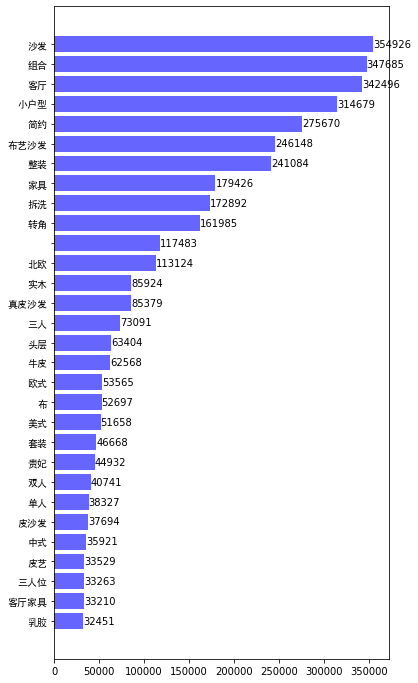

In [18]:
import matplotlib
from matplotlib import pyplot as plt
font = matplotlib.font_manager.FontProperties(fname = './data/simhei.ttf') # Importing font  # Note ↓ （2）

index = np.arange(df_w_s.word.size) # Note ↓ （3）

plt.figure(figsize = (6, 12)) 
plt.barh(index,              # Giving the position on the y-axis  # Note ↓ （4）
         df_w_s.w_s_sum,     # https://www.jianshu.com/p/d103917cd481 
         color = 'blue', 
         align = 'center',
         alpha = 0.6)        # alpha: between 0 (transparent) and 1 (opaque)

plt.yticks(index,  list(df_w_s.word), fontproperties = font)  # Setting y-axis
                                                              # plt.yticks(location, content, fontproperties)
                                                              # Note ↓ （5）

for y,x in zip(index, df_w_s.w_s_sum): # Note ↓ （6） 
    plt.text(x, y, "%.0f" %x, ha = 'left', va = 'center') # Note ↓ （7）  # Note ↓ （8）
    
plt.show()

Notes:  
  
1. DataFrame.sort_values(self, by, axis = 0, ascending = True, inplace = False, kind = 'quicksort', na_position = 'last')  
   Sort by the values along either axis.  

DataFrame.sort_values(

**self,**   
  
**by,**  
> str or list of str  
> Name or list of names to sort by.  
> if axis is 0 or 'index' then by may contain index levels and/or column labels  
> if axis is 1 or 'columns' then by may contain column levels and/or index labels  
> Changed in version 0.23.0: Allow specifying index or column level names.  

**axis = 0,**  
> {0 or 'index', 1 or 'columns'}, default 0  
> Axis to be sorted.  

**ascending = True,**  
> bool or list of bool, default True  
> Sort ascending vs. descending. Specify list for multiple sort orders. If this is a list of bools, must match the length of the by.  

**inplace = False,**    
> bool, default False   
> If True, perform operation in-place.   

**kind = 'quicksort',**   
> {'quicksort', 'mergesort', 'heapsort'}, default 'quicksort'  
> Choice of sorting algorithm. See also ndarray.np.sort for more information.  
> mergesort is the only stable algorithm. For DataFrames, this option is only applied when sorting on a single column or label. 

**na_position='last'**)  
> {'first', 'last'}, default 'last'  
> Puts NaNs at the beginning if first; last puts NaNs at the end.

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sort_values.html


2. matplotlib.font_manager  
English version: https://matplotlib.org/3.1.1/api/font_manager_api.html  
https://docs.w3cub.com/matplotlib~3.0/font_manager_api/#matplotlib.font_manager.FontEntry  
中文版本： https://www.osgeo.cn/matplotlib/api/font_manager_api.html   
  
  
3. numpy.arange(start, stop, step, dtype = None)  
   (1) Return evenly spaced values within a given interval.  
   (2) Values are generated within the half-open interval [start, stop) (in other words, the interval including start but excluding stop).   
   (3) For integer arguments the function is equivalent to the Python built-in range function, but returns an ndarray rather than a list.  
   (4) When using a non-integer step, such as 0.1, the results will often not be consistent. It is better to use numpy.linspace for these cases.  
  
Parameters:	
**start** : 
> number, optional  
> Start of interval.  
> The interval includes this value.  
> The default start value is 0.  

**stop** :   
> number  
> End of interval.   
> The interval does not include this value, except in some cases where step is not an integer and floating point round-off affects the length of out.  

**step** :   
> number, optional   
> Spacing between values.  
> For any output out, this is the distance between two adjacent values, out[i+1] - out[i].   
> The default step size is 1.   
> If step is specified as a position argument, start must also be given.  

**dtype** :   
> dtype  
> The type of the output array.  
> If dtype is not given, infer the data type from the other input arguments.  

Returns:	 
arange : ndarray  
Array of evenly spaced values.  
For floating point arguments, the length of the result is ceil((stop - start)/step). Because of floating point overflow, this rule may result in the last element of out being greater than stop.  

https://docs.scipy.org/doc/numpy/reference/generated/numpy.arange.html  


4. matplotlib.pyplot.barh(y, width, height = 0.8, left = None, *, align = 'center', **kwargs)  
   (1) Make a horizontal bar plot.    
   (2) The bars are positioned at y with the given alignment. Their dimensions are given by width and height. The horizontal baseline is left (default 0).  
   (3) Each of y, width, height, and left may either be a scalar applying to all bars, or it may be a sequence of length N providing a separate value for each bar.  

Parameters:	  
**y** : 
> scalar or array-like  
> The y coordinates of the bars. See also align for the alignment of the bars to the coordinates.  

**width** :   
> scalar or array-like  
> The width(s) of the bars.  

**height** :   
> sequence of scalars, optional, default: 0.8  
> The heights of the bars.  

**left** :   
> sequence of scalars  
> The x coordinates of the left sides of the bars (default: 0).  

**align** :   
> {'center', 'edge'}, optional, default: 'center'    
> Alignment of the base to the y coordinates:  
> (1) 'center': Center the bars on the y positions.  
> (2) 'edge': Align the bottom edges of the bars with the y positions.  
> To align the bars on the top edge pass a negative height and align='edge'. 

https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.barh.html  


5. matplotlib.pyplot.yticks(ticks = None, labels = None, **kwargs)  
https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.yticks.html     


6. zip():  
Matching the values of index and df_w_s.w_s_sum one by one to form a tuple.  
https://www.runoob.com/python/python-func-zip.html   


7. matplotlib.pyplot.text(x, y, s, fontdict = None, withdash = False, **kwargs):  

Parameters:

**x, y**：(表示坐标)  
> calars  
> The position to place the text.  
> By default, this is in data coordinates. The coordinate system can be changed using the transform parameter.  

**s**：  
> str  
> The text.  

**fontdict**：   
> dictionary, optional, default: None
> A dictionary to override the default text properties.    
> If fontdict is None, the defaults are determined by your rc parameters.    

**withdash** :     
> boolean, optional, default: False    
> Creates a TextWithDash instance instead of a Text instance.    

**kw**：    
> fontsize = 12,   
> horizontalalignment = 'center' or ha='cener'  
> verticalalignment = 'center' or va='center'  

English version: https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.text.html  
中文版本： https://blog.csdn.net/lanchunhui/article/details/52934347

8. %.0f   
%.0f 是输出 float 型，小数点以下占0位。  
也就是输出浮点数的整数部分，不输出小数点和小数点以下部分。小数部分 4 舍 5 入。  

## (6) Statistical Analysis of the Price Distribution of Commodities
#### In order to make the visualization more intuitive, only considering products with price less than 20,000.

In [19]:
data.head()

,raw_title,view_price,province,city,sales_volume
0,北欧风格小户型实木架客厅L型布艺沙发组合,3480.0,广东,佛山,328
1,凯哲家具欧式真皮沙发 头层牛皮雕花实木客厅整装转角沙发组合,7400.0,广东,佛山,111
2,雅居汇 欧式真皮转角沙发实木雕花客厅家具组合美式真皮转角沙发,18800.0,广东,佛山,25
3,斯帝罗兰简约现代真皮沙发组合整装客厅转角头层牛皮三人沙发家具,8699.0,广东,江门,93
4,!【新款】现顾家kuka北欧布艺沙发客厅大小户型现代简约组合2037,2999.0,浙江,杭州,142


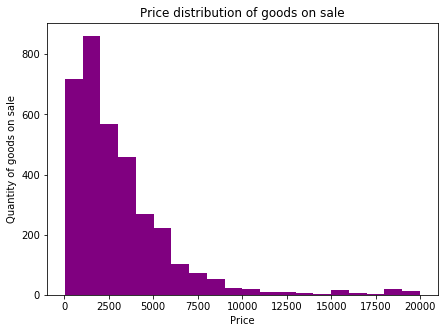

In [20]:
data_p = data[data['view_price'] < 20000]  # Analyzing products with price less than 20,000. 

plt.figure(figsize = (7, 5))
plt.hist(data_p['view_price'], bins = 20, color = 'purple') # Note ↓ （1）
plt.xlabel('Price')                                         # bins =20 : width for every bin is (20,000-0)/20 = 1,000
plt.ylabel('Quantity of goods on sale')
plt.title('Price distribution of goods on sale')
plt.show()

## Conclusion:  
1. The largest number of sofas on sale with a price between ￥1,000-2,000.  
2. The prices of sofas are mainly between ￥0-4,000.   
3. The quantity of goods shows a downward trend with the price rising. The higher the price, the less goods are on sale.  

Notes:   
  
1. matplotlib.pyplot.hist(x, bins = None, range = None, density = None, weights = None, cumulative = False, bottom = None, histtype = 'bar', align = 'mid', orientation = 'vertical', rwidth = None, log = False, color = None, label = None, stacked = False, normed = None, *, data = None, **kwargs)  
(1) Plot a histogram (直方图).   
(2) Compute and draw the histogram of x. The return value is a tuple (n, bins, patches) or ([n0, n1, ...], bins, [patches0, patches1,...]) if the input contains multiple data. See the documentation of the weights parameter to draw a histogram of already-binned data.  
(3) Multiple data can be provided via x as a list of datasets of potentially different length ([x0, x1, ...]), or as a 2-D ndarray in which each column is a dataset. Note that the ndarray form is transposed relative to the list form.  
(4) Masked arrays are not supported at present.  

Parameters:

matplotlib.pyplot.hist(

**x,**  
> (1) (n,) array or sequence of (n,) arrays  
> (2) Input values, this takes either a single array or a sequence of arrays which are not required to be of the same length.   

**bins = None,** 
> (1) int or sequence or str, optional  
> (2) If an integer is given, bins + 1 bin edges are calculated and returned, consistent with numpy.histogram.  
> (3) If bins is a sequence, gives bin edges, including left edge of first bin and right edge of last bin. In this case, bins is returned unmodified.    
> (4) All but the last (righthand-most) bin is half-open. In other words, if bins is: [1, 2, 3, 4], then the first bin is [1, 2) (including 1, but excluding 2) and the second [2, 3). The last bin, however, is [3, 4], which includes 4.  
> (5) Unequally spaced bins are supported if bins is a sequence.   
> (6) With Numpy 1.11 or newer, you can alternatively provide a string describing a binning strategy, such as 'auto', 'sturges', 'fd', 'doane', 'scott', 'rice' or 'sqrt', see numpy.histogram.   
> (7) The default is taken from rcParams["hist.bins"] = 10.  

**range = None,**   
> (1) tuple or None, optional  
> (2) The lower and upper range of the bins. Lower and upper outliers are ignored. If not provided, range is (x.min(), x.max()). Range has no effect if bins is a sequence.     
> (3) If bins is a sequence or range is specified, autoscaling is based on the specified bin range instead of the range of x.   
> (4) Default is None       

**density = None,**
> (1) bool, optional  
> (2) If True, the first element of the return tuple will be the counts normalized to form a probability density, i.e., the area (or integral) under the histogram will sum to 1. This is achieved by dividing the count by the number of observations times the bin width and not dividing by the total number of observations. If stacked is also True, the sum of the histograms is normalized to 1.  
> (3) Default is None for both normed and density. If either is set, then that value will be used. If neither are set, then the args will be treated as False.   
> (4) If both density and normed are set an error is raised.  

**weights = None,**  
> (1) (n, ) array_like or None, optional  
> (2) An array of weights, of the same shape as x. Each value in x only contributes its associated weight towards the bin count (instead of 1). If normed or density is True, the weights are normalized, so that the integral of the density over the range remains 1.  
> (3) Default is None.    
> (4) This parameter can be used to draw a histogram of data that has already been binned, e.g. using np.histogram (by treating each bin as a single point with a weight equal to its count)  
  
>counts, bins = np.histogram(data)  
 plt.hist(bins[:-1], bins, weights=counts)  
  
>(or you may alternatively use bar()).  

**cumulative = False,**    
> (1) bool, optional  
> (2) If True, then a histogram is computed where each bin gives the counts in that bin plus all bins for smaller values. The last bin gives the total number of datapoints. If normed or density is also True then the histogram is normalized such that the last bin equals 1. If cumulative evaluates to less than 0 (e.g., -1), the direction of accumulation is reversed. In this case, if normed and/or density is also True, then the histogram is normalized such that the first bin equals 1.  
> (3) Default is False

**bottom = None,**  
> (1) array_like, scalar, or None  
> (2) Location of the bottom baseline of each bin. If a scalar, the base line for each bin is shifted by the same amount. If an array, each bin is shifted independently and the length of bottom must match the number of bins. If None, defaults to 0.  
> (3) Default is None  

**histtype = 'bar',**  
> (1) {'bar', 'barstacked', 'step', 'stepfilled'}, optional  
> (2) The type of histogram to draw.  
> * 'bar' is a traditional bar-type histogram. If multiple data are given the bars are arranged side by side.  
> * 'barstacked' is a bar-type histogram where multiple data are stacked on top of each other.  
> * 'step' generates a lineplot that is by default unfilled.  
> * 'stepfilled' generates a lineplot that is by default filled.  
> (3) Default is 'bar'

**align = 'mid',**  
> (1) {'left', 'mid', 'right'}, optional   
> (2) Controls how the histogram is plotted.   
> * 'left': bars are centered on the left bin edges.  
> * 'mid': bars are centered between the bin edges.  
> * 'right': bars are centered on the right bin edges.  
> (3) Default is 'mid'  

**orientation = 'vertical',**  
> (1) {'horizontal', 'vertical'}, optional  
> (2) If 'horizontal', barh will be used for bar-type histograms and the bottom kwarg will be the left edges.  

**rwidth = None,**  
> (1) scalar or None, optional  
> (2) The relative width of the bars as a fraction of the bin width. If None, automatically compute the width.  
> (3) Ignored if histtype is 'step' or 'stepfilled'.
> (4) Default is None  

**log = False,**  
> (1) bool, optional  
> (2) If True, the histogram axis will be set to a log scale. If log is True and x is a 1D array, empty bins will be filtered out and only the non-empty (n, bins, patches) will be returned.   
> (3) Default is False  

**color = None,**
> (1) color or array_like of colors or None, optional  
> (2) Color spec or sequence of color specs, one per dataset. Default (None) uses the standard line color sequence.  
> (3) Default is None  

**label = None,**
> (1) str or None, optional  
> (2) String, or sequence of strings to match multiple datasets. Bar charts yield multiple patches per dataset, but only the first gets the label, so that the legend command will work as expected.  
> (3) Default is None  

**stacked = False,**  
> (1) bool, optional  
> (2) If True, multiple data are stacked on top of each other If False multiple data are arranged side by side if histtype is 'bar' or on top of each other if histtype is 'step'  
> (3) Default is False  

**normed = None,**   
> (1) bool, optional  
> (2) Deprecated; use the density keyword argument instead.  

***,**

**data = None,**

****kwargs)**   
> Patch properties  

https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.hist.html

## (7) Statistical Analysis of the Sales Distribution of Commodities
#### In order to make the visualization more intuitive, only considering products with sales more than 100, less than 20,000.

Proportion of goods which sales volume is in the range of 100 to 2000: 0.271


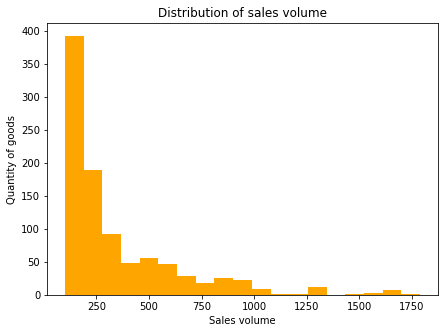

In [21]:
data_s = data[(data['sales_volume'] > 100) & (data['sales_volume'] < 2000)]
    
print('Proportion of goods which sales volume is in the range of 100 to 2000: %0.3f' %(len(data_s) / len(data)))

plt.figure(figsize = (7, 5))
plt.hist(data_s['sales_volume'], bins = 19, color = 'orange') # bins =19 : width for every bin is (2,000-100)/19 = 100 
plt.xlabel('Sales volume')
plt.ylabel('Quantity of goods')
plt.title('Distribution of sales volume')
plt.show()

## Conclusion:  
1. Goods with a sales volume in the range of 100 to 2000 accounted for only 27.1%, of which the sales of 100-200 is the most, followed by 200-300.  
2. When the sales volume is between 100 and 500, the quantity of goods shows a downward trend with the rising of sales volume, and the trend is steep, sales of most goods are very low.  
3. There are few goods with sales volume more than 1000.

## (8) Average Sales Volume Distribution of Commodities in Different Price Ranges

In [22]:
# According to the prices of goods, the price range is divided into 10 equal parts,
# and match each commodity with the corresponding price range.
data['price'] = data.view_price.astype('int')
data['price_range'] = pd.qcut(data.price, 10) # Note ↓ （1） 
                                          
data.head()

,raw_title,view_price,province,city,sales_volume,price,price_range
0,北欧风格小户型实木架客厅L型布艺沙发组合,3480.0,广东,佛山,328,3480,"(2980.0, 3699.0]"
1,凯哲家具欧式真皮沙发 头层牛皮雕花实木客厅整装转角沙发组合,7400.0,广东,佛山,111,7400,"(6600.0, 99002.0]"
2,雅居汇 欧式真皮转角沙发实木雕花客厅家具组合美式真皮转角沙发,18800.0,广东,佛山,25,18800,"(6600.0, 99002.0]"
3,斯帝罗兰简约现代真皮沙发组合整装客厅转角头层牛皮三人沙发家具,8699.0,广东,江门,93,8699,"(6600.0, 99002.0]"
4,!【新款】现顾家kuka北欧布艺沙发客厅大小户型现代简约组合2037,2999.0,浙江,杭州,142,2999,"(2980.0, 3699.0]"


In [23]:
df_s_g = data[['sales_volume', 'price_range']]
df_s_g

,sales_volume,price_range
0,328,"(2980.0, 3699.0]"
1,111,"(6600.0, 99002.0]"
2,25,"(6600.0, 99002.0]"
3,93,"(6600.0, 99002.0]"
4,142,"(2980.0, 3699.0]"
...,...,...
4387,230,"(39.999, 588.1]"
4388,125,"(1813.8, 2368.0]"
4389,31,"(2980.0, 3699.0]"
4390,942,"(39.999, 588.1]"


In [24]:
# Calculating the average sales volume of goods belonging to the same price range.
df_s_g = data[['sales_volume', 'price_range']].groupby('price_range').mean().reset_index() # Note ↓ （2）

df_s_g

,price_range,sales_volume
0,"(39.999, 588.1]",309.817664
1,"(588.1, 998.2]",134.505714
2,"(998.2, 1380.0]",246.216524
3,"(1380.0, 1813.8]",177.845272
4,"(1813.8, 2368.0]",101.056338
5,"(2368.0, 2980.0]",123.955923
6,"(2980.0, 3699.0]",112.200000
7,"(3699.0, 4821.0]",52.799427
8,"(4821.0, 6600.0]",35.366762
9,"(6600.0, 99002.0]",27.405714


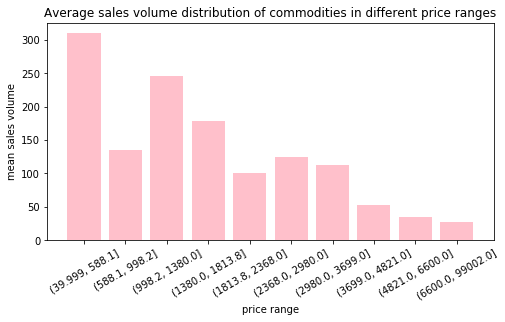

In [25]:
index = np.arange(df_s_g.price_range.size)
plt.figure(figsize = (8, 4))
plt.bar(index, df_s_g.sales_volume, color = 'pink')
plt.xticks(index, df_s_g.price_range, rotation = 30)
plt.xlabel('price range')
plt.ylabel('mean sales volume')
plt.title('Average sales volume distribution of commodities in different price ranges')
plt.show()

## Conclusion:  
1. The average sales volume of goods with price between ￥40-588 is the highest, followed by ￥998-1380, and the lowest with price over ￥6600;
2. Overall, it shows a downward trend. 

Notes:    

1. pandas.qcut(x, q, labels = None, retbins = False, precision = 3, duplicates = 'raise')  
(1) Quantile-based discretization function.   
(2) Discretize variable into equal-sized buckets based on rank or based on sample quantiles.  

Parameters:	 

**x** : 1d ndarray or Series  

**q** : integer or array of quantiles  
> Number of quantiles. 10 for deciles, 4 for quartiles, etc. Alternately array of quantiles, e.g. [0, .25, .5, .75, 1.] for quartiles.  

**labels** : array or boolean, default None  
> Used as labels for the resulting bins.   
> Must be of the same length as the resulting bins.   
> If False, return only integer indicators of the bins.  

**retbins** : bool, optional
> Whether to return the (bins, labels) or not.   
> Can be useful if bins is given as a scalar.    

**precision** : int, optional  
> The precision at which to store and display the bins labels.  

**duplicates** : {default ‘raise’, ‘drop’}, optional  
> If bin edges are not unique, raise ValueError or drop non-uniques.   

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.qcut.html


2. DataFrame.groupby(self, by = None, axis = 0, level = None, as_index = True, sort = True, group_keys = True, squeeze = False, observed = False, **kwargs)    
(1) Group DataFrame or Series using a mapper or by a Series of columns.  
(2) A groupby operation involves some combination of splitting the object, applying a function, and combining the results. This can be used to group large amounts of data and compute operations on these groups.  

Parameters:	  

**by** : mapping, function, label, or list of labels   
> Used to determine the groups for the groupby.   
> * If by is a function, it’s called on each value of the object’s index.   
> * If a dict or Series is passed, the Series or dict VALUES will be used to determine the groups (the Series’ values are first aligned; see .align() method).    
> * If an ndarray is passed, the values are used as-is determine the groups. A label or list of labels may be passed to group by the columns in self. Notice that a tuple is interpreted as a (single) key.  

**axis** : {0 or 'index', 1 or 'columns'}, default 0  
> Split along rows (0) or columns (1).  

**level** : int, level name, or sequence of such, default None  
> If the axis is a MultiIndex (hierarchical), group by a particular level or levels.  

**as_index** : bool, default True
> For aggregated output, return object with group labels as the index.   
> Only relevant for DataFrame input.   
> as_index = False is effectively 'SQL-style' grouped output.  

**sort** : bool, default True  
> Sort group keys.   
> Get better performance by turning this off.   
> Note this does not influence the order of observations within each group.  
> Groupby preserves the order of rows within each group.  

**group_keys** : bool, default True  
> When calling apply, add group keys to index to identify pieces.  

**squeeze** : bool, default False  
> Reduce the dimensionality of the return type if possible, otherwise return a consistent type.  

**observed** : bool, default False   
> This only applies if any of the groupers are Categoricals.   
> * If True: only show observed values for categorical groupers.   
> * If False: show all values for categorical groupers.  

****kwargs**    
> Optional, only accepts keyword argument 'mutated' and is passed to groupby.  

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html

## (9) Analysis of the Influence of Price on Sales Volume
#### In order to make the visualization more intuitive, only considering products with price less than 20,000.

In [26]:
data_p

,raw_title,view_price,province,city,sales_volume
0,北欧风格小户型实木架客厅L型布艺沙发组合,3480.0,广东,佛山,328
1,凯哲家具欧式真皮沙发 头层牛皮雕花实木客厅整装转角沙发组合,7400.0,广东,佛山,111
2,雅居汇 欧式真皮转角沙发实木雕花客厅家具组合美式真皮转角沙发,18800.0,广东,佛山,25
3,斯帝罗兰简约现代真皮沙发组合整装客厅转角头层牛皮三人沙发家具,8699.0,广东,江门,93
4,!【新款】现顾家kuka北欧布艺沙发客厅大小户型现代简约组合2037,2999.0,浙江,杭州,142
...,...,...,...,...,...
4387,奶茶甜品店咖啡西餐厅洽谈桌椅组合现代简约休闲皮艺双人卡座沙发,280.0,浙江,湖州,230
4388,北欧简约布艺沙发大小户型客厅转角储物可拆洗L/U型整装组合家具,1980.0,广东,佛山,125
4389,美式乡村复古工艺意大利进口油蜡皮头层真牛皮沙发1+2+3组合,3499.0,广东,佛山,31
4390,办公沙发简约会客接待商务三人位沙发办公室家具时尚沙发茶几组合,558.0,广东,佛山,942


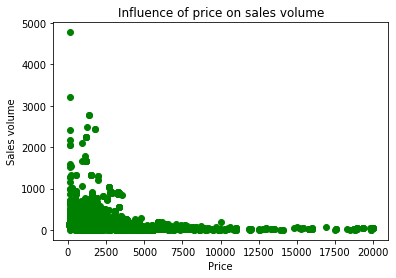

In [27]:
fig, ax = plt.subplots() # Note ↓ （1）  # Note ↓ （2）
ax.scatter(data_p['view_price'], data_p['sales_volume'], color='green') # Note ↓ （3） 
ax.set_xlabel('Price')
ax.set_ylabel('Sales volume')
ax.set_title('Influence of price on sales volume')
plt.show()

## Conclusion:  
1. General trend: the lower the price of a commodity, the higher its sales volume.  
2. Commodity with a price range of ￥0-4000 are easier to sell.   

Notes:   
  
1. fig, ax = plt.subplots()  
(1) plt.subplots() is a function that returns a tuple containing a figure and axes object(s).   
(2) Thus when using fig, ax = plt.subplots(), you unpack this tuple into the variables fig and ax.   
(3) Having fig is useful if you want to change figure-level attributes or save the figure as an image file later (e.g. with fig.savefig('yourfilename.png')). You certainly don't have to use the returned figure object but many people do use it later so it's common to see.    
(4) Also, all axes objects (the objects that have plotting methods), have a parent figure object anyway, thus:
fig, ax = plt.subplots() is more concise than this:  
> fig = plt.figure()  
> ax = fig.add_subplot(111)   

中文版本： https://blog.csdn.net/htuhxf/article/details/82986440    
English version: https://stackoverflow.com/questions/34162443/why-do-many-examples-use-fig-ax-plt-subplots-in-matplotlib-pyplot-python     
  

2. the relationship between fig and ax:    https://blog.csdn.net/wuyuanmang9995/article/details/81017462     


3. Axes.scatter(self, x, y, s = None, c = None, marker = None, cmap = None, norm = None, vmin = None, vmax = None, alpha = None, linewidths = None, verts = None, edgecolors = None, *, plotnonfinite = False, data = None, **kwargs)    
A scatter plot of y vs x with varying marker size and/or color.  

Parameters:	  

**x, y** : array_like, shape (n, )
> The data positions.

**s** : scalar or array_like, shape (n, ), optional  
> The marker size in points**2. Default is rcParams['lines.markersize'] ** 2.  

**c** : color, sequence, or sequence of color, optional  
> (1) The marker color. Possible values:   
> * A single color format string.   
> * A sequence of color specifications of length n.  
> * A sequence of n numbers to be mapped to colors using cmap and norm.  
> * A 2-D array in which the rows are RGB or RGBA.  
> 
> (2) Note that c should not be a single numeric RGB or RGBA sequence because that is indistinguishable from an array of values to be colormapped. If you want to specify the same RGB or RGBA value for all points, use a 2-D array with a single row. Otherwise, value- matching will have precedence in case of a size matching with x and y.  
> 
> (3) Defaults to None. In that case the marker color is determined by the value of color, facecolor or facecolors. In case those are not specified or None, the marker color is determined by the next color of the Axes' current "shape and fill" color cycle. This cycle defaults to rcParams["axes.prop_cycle"] = cycler('color', ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']).    

**marker** : MarkerStyle, optional    
> The marker style. marker can be either an instance of the class or the text shorthand for a particular marker.    
> Defaults to None, in which case it takes the value of rcParams["scatter.marker"] = 'o' = 'o'. See markers for more information about marker styles.  

**cmap** : Colormap, optional, default: None  
> A Colormap instance or registered colormap name.  
> cmap is only used if c is an array of floats. If None, defaults to rc image.cmap.  

**norm** : Normalize, optional, default: None    
> A Normalize instance is used to scale luminance data to 0, 1.   
> norm is only used if c is an array of floats. If None, use the default colors.Normalize.    

**vmin, vmax** : scalar, optional, default: None  
> vmin and vmax are used in conjunction with norm to normalize luminance data. If None, the respective min and max of the color array is used.     
> vmin and vmax are ignored if you pass a norm instance.    

**alpha** : scalar, optional, default: None    
> The alpha blending value, between 0 (transparent) and 1 (opaque).    

**linewidths** : scalar or array_like, optional, default: None    
> The linewidth of the marker edges.   
> Note: The default edgecolors is 'face'. You may want to change this as well. If None, defaults to rcParams lines.linewidth.   

**edgecolors** : {'face', 'none', None} or color or sequence of color, optional.    
> (1) The edge color of the marker.   
>  
> (2) Possible values:    
> * 'face': The edge color will always be the same as the face color.    
> * 'none': No patch boundary will be drawn.      
> * A Matplotlib color or sequence of color.   
>  
> (3) Defaults to None, in which case it takes the value of rcParams["scatter.edgecolors"] = 'face' = 'face'.   
>  
> (4) For non-filled markers, the edgecolors kwarg is ignored and forced to 'face' internally.    

**plotnonfinite** : boolean, optional, default: False     
> Set to plot points with nonfinite c, in conjunction with set_bad.   
  	
****kwargs** : Collection properties  

https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.axes.Axes.scatter.html?highlight=scatter#matplotlib.axes.Axes.scatter    

## (10) Analysis of the Influence of Price on Sales  

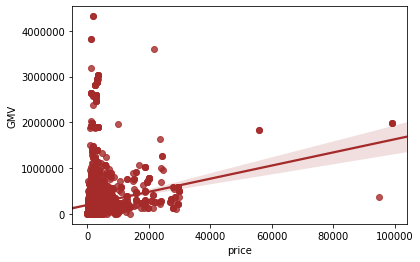

In [28]:
data['GMV'] = data['price'] * data['sales_volume']

import seaborn as sns  
sns.regplot(x = 'price', y = 'GMV', data = data, color = 'brown') # Note ↓ （1）

## Conclusion:  
1. General trend: as can be seen from the linear regression fitting line, with the increase of price, the total sales shows an upward trend.  
2. The prices of most commodities are low, and the total sales is also low. 

Notes:   

1. seaborn.regplot(x, y, data = None, x_estimator = None, x_bins = None, x_ci = 'ci', scatter = True, fit_reg = True, ci = 95, n_boot = 1000, units = None, order = 1, logistic = False, lowess = False, robust = False, logx = False, x_partial = None, y_partial = None, truncate = False, dropna = True, x_jitter = None, y_jitter = None, label = None, color = None, marker = 'o', scatter_kws = None, line_kws = None, ax = None)    

(1) Plot data and a linear regression model fit.    

(2) There are a number of mutually exclusive options for estimating the regression model. See the tutorial for more information.

Parameters：  

**x, y**：string, series, or vector array   
> (1) Input variables. 
> (2) If strings, these should correspond with column names in data.   
> (3) When pandas objects are used, axes will be labeled with the series name.    

**data**：DataFrame     
> Tidy (“long-form”) dataframe where each column is a variable and each row is an observation.    

**x_estimator**：callable that maps vector -> scalar, optional    
> (1) Apply this function to each unique value of x and plot the resulting estimate.  
> (2) This is useful when x is a discrete variable.  
> (3) If x_ci is given, this estimate will be bootstrapped and a confidence interval will be drawn.   

**x_bins**：int or vector, optional  
> (1) Bin the x variable into discrete bins and then estimate the central tendency and a confidence interval.    
> (2) This binning only influences how the scatterplot is drawn; the regression is still fit to the original data.   
> (3) This parameter is interpreted either as the number of evenly-sized (not necessary spaced) bins or the positions of the bin centers.   
> (4) When this parameter is used, it implies that the default of x_estimator is numpy.mean.    

**x_ci**：“ci”, “sd”, int in [0, 100] or None, optional    
> (1) Size of the confidence interval used when plotting a central tendency for discrete values of x.   
> (2) If "ci", defer to the value of the ci parameter.   
> (3) If "sd", skip bootstrapping and show the standard deviation of the observations in each bin.  

**scatter**：bool, optional    
> If True, draw a scatterplot with the underlying observations (or the x_estimator values).  

**fit_reg**：bool, optional  
> If True, estimate and plot a regression model relating the x and y variables.  

**ci**：int in [0, 100] or None, optional   
> (1) Size of the confidence interval for the regression estimate.   
> (2) This will be drawn using translucent bands around the regression line.   
> (3) The confidence interval is estimated using a bootstrap; for large datasets, it may be advisable to avoid that computation by setting this parameter to None.  

**n_boot**：int, optional  
> (1) Number of bootstrap resamples used to estimate the ci.   
> (2) The default value attempts to balance time and stability; you may want to increase this value for “final” versions of plots.   

**units**：variable name in data, optional  
> (1) If the x and y observations are nested within sampling units, those can be specified here.   
> (2) This will be taken into account when computing the confidence intervals by performing a multilevel bootstrap that resamples both units and observations (within unit).   
> (3) This does not otherwise influence how the regression is estimated or drawn.  

**order**：int, optional  
> If order is greater than 1, use numpy.polyfit to estimate a polynomial regression.  

**logistic**：bool, optional
> (1) If True, assume that y is a binary variable and use statsmodels to estimate a logistic regression model.   
> (2) Note that this is substantially more computationally intensive than linear regression, so you may wish to decrease the number of bootstrap resamples (n_boot) or set ci to None.  

**lowess**：bool, optional
> If True, use statsmodels to estimate a nonparametric lowess model (locally weighted linear regression). Note that confidence intervals cannot currently be drawn for this kind of model.  

**robust**：bool, optional
> (1) If True, use statsmodels to estimate a robust regression. This will de-weight outliers.   
> (2) Note that this is substantially more computationally intensive than standard linear regression, so you may wish to decrease the number of bootstrap resamples (n_boot) or set ci to None.  

**logx**：bool, optional
> (1) If True, estimate a linear regression of the form y ~ log(x), but plot the scatterplot and regression model in the input space.  
> (2) Note that x must be positive for this to work.  

**{x,y}_partial**：strings in data or matrices  
> Confounding variables to regress out of the x or y variables before plotting.  

**truncate**：bool, optional
> (1) By default, the regression line is drawn to fill the x axis limits after the scatterplot is drawn.  
> (2) If truncate is True, it will instead by bounded by the data limits.  

**{x,y}_jitter**：floats, optional  
> (1) Add uniform random noise of this size to either the x or y variables.  
> (2) The noise is added to a copy of the data after fitting the regression, and only influences the look of the scatterplot.   
> (3) This can be helpful when plotting variables that take discrete values.  

**label**：string  
> Label to apply to ether the scatterplot or regression line (if scatter is False) for use in a legend.  

**color**：matplotlib color  
> Color to apply to all plot elements; will be superseded by colors passed in scatter_kws or line_kws.  

**marker**：matplotlib marker code  
> Marker to use for the scatterplot glyphs.  

**{scatter,line}_kws**：dictionaries  
> Additional keyword arguments to pass to plt.scatter and plt.plot.  

**ax**：matplotlib Axes, optional  
> Axes object to draw the plot onto, otherwise uses the current Axes.  

https://www.cntofu.com/book/172/docs/28.md
http://seaborn.pydata.org/

## (11) Analysis of the Regional Distribution of Commodities

In [29]:
r_d_c = data.province.value_counts()
r_d_c

广东    2421
浙江     339
江苏     271
江西     191
上海     106
北京      65
四川      56
山东      23
福建      11
湖北       6
河北       5
安徽       4
天津       2
陕西       1
湖南       1
Name: province, dtype: int64

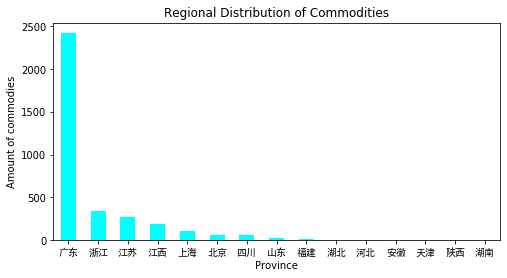

In [30]:
plt.figure(figsize = (8,4))
data.province.value_counts().plot(kind = 'bar', color = 'cyan') # Note ↓ （1）
plt.xticks(rotation = 0, fontproperties = font) # Note ↓ （2）  
plt.xlabel('Province')
plt.ylabel('Amount of commodies')
plt.title('Regional Distribution of Commodities')
plt.show()

In [31]:
from pyecharts import Map # Note ↓ （3）

attr = r_d_c.index
value = r_d_c.values

map = Map("Regional Distribution of Commodities", width = 1200, height = 600)
map.add("Regional Distribution of Commodities", attr, value, maptype ="china",  is_visualmap = True, visual_text_color = '#000')

map.render(path="Regional Distribution of Commodities.html")

Interactive page:
file:///C:/Users/vince/Desktop/fintech/Introduction%20to%20Data%20Science%20Programming/Project/Regional%20Distribution%20of%20Commodities.html

## Conclusion:  
1. The number of commodities from Guangdong Province is the largest, followed by Zhejiang and Jiangsu.  
2. In particular, the number of goods from Guangdong far exceeds that from Jiangsu, Zhejiang, Shanghai and other places, indicating that for the sub category of sofa, stores in Guangdong are dominant.  
3. The number of commodities from Jiangsu, Zhejiang and Shanghai is almost the same.  

Notes:

1. Series.plot is both a callable method and a namespace attribute for specific plotting methods of the form Series.plot.<kind>.  

Englishi version: https://pandas.pydata.org/pandas-docs/stable/reference/series.html#plotting   
中文版本： https://blog.csdn.net/jinlong_xu/article/details/70175107   


2. python xticks(locs, labels, **kwargs)  

Parameters:

**locs**:
> (array_like, optional), which indicates the place where the x-axis tick marks are displayed, that is, the place where the marks are placed.  

**labels**:  
> (array_like, optional)
> Indicates the label added in the location represented by the locs. 
> If labels is not assigned, the number added in these locations is the number in the locs.

****kwargs**:  
> can be used to set the fontproperties, inclination and color of label.  

https://blog.csdn.net/Poul_henry/article/details/82590392  


3. pyecharts: Map   
> (1) Pay attention to the version: pip install pyecharts==0.1.9.4    (==两边没有空格）  
> (2) 关于为什么不选择1.0 version:   
https://www.cnblogs.com/dgwblog/p/11811562.html     
http://www.361way.com/pyecharts/6172.html    
> (3) 使用前要下载新的地图扩展包:    
https://pyecharts.readthedocs.io/zh/latest/zh-cn/customize_map/#version-057 (1,2已经下载)  
https://blog.csdn.net/KysonLai/article/details/81487633    
> (4) Examples:
https://blog.csdn.net/XC_LMH/article/details/86182267  
https://blog.csdn.net/weixin_40683253/article/details/87859970#%E4%BD%BF%E7%94%A8%20pyecharts%20%E6%A8%A1%E5%9D%97%E4%B8%AD%E7%9A%84%20map%20%E5%87%BD%E6%95%B0%EF%BC%9A  
> (5) Official tutorial:  
http://pyecharts.org/#/zh-cn/intro  
> (6) 拓展:  
Apache ECharts: https://echarts.apache.org/zh/cheat-sheet.html  